# Simulations for multi-resolution deblending

In this notebook I test multi-resolution on simulated images using the galsim package.

In [1]:
import scarlet
import galsim
from astropy import wcs as WCS
import time
from mr_tools import galsim_compare_tools as gct
from mr_tools.simulations import Simulation, load_surveys, chi
import proxmin
import pickle

# Import Packages and setup
import numpy as np
import scarlet.display
from scarlet.display import AsinhMapping
from scarlet import Starlet
from scarlet.wavelet import mad_wavelet
import scipy.stats as scs
from scarlet.initialization import build_initialization_image, set_spectra_to_match
from functools import partial
from scarlet_extensions.initialization.detection import makeCatalog, Data
from scarlet_extensions.scripts.runner import Runner
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# use a better colormap and don't interpolate the pixels
matplotlib.rc('image', cmap='gist_stern')
matplotlib.rc('image', interpolation='none')

/Users/remy/opt/anaconda3/lib/python3.8/site-packages/proxmin-0.6.11-py3.8.egg/proxmin/nmf.py:64: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if W is 1:


In [2]:
%pylab inline
# Setup: declaring survey properties, loading catalog and making sure we have pretty colorbars
data_dir='/Users/remy/Desktop/LSST_Project/GalSim/examples/data'

HST, EUCLID, ROMAN, HSC, RUBIN = load_surveys()
print(RUBIN)
center_ra = 19.3*galsim.hours     # The RA, Dec of the center of the image on the sky
center_dec = -33.1*galsim.degrees

cat = galsim.COSMOSCatalog(dir=data_dir, file_name = 'real_galaxy_catalog_23.5_example.fits')

Populating the interactive namespace from numpy and matplotlib
{'name': 'RUBIN', 'pixel': 0.2, 'psf': array([0.327, 0.31 , 0.297, 0.285, 0.276, 0.267]), 'channels': ['u', 'g', 'r', 'i', 'z', 'y'], 'sky': array([22.9, 22.3, 21.2, 20.5, 19.6, 18.6]), 'exp_time': array([1680, 2400, 5520, 5520, 4800, 4800]), 'zero_point': array([ 9.16, 50.7 , 43.7 , 32.36, 22.68, 10.58])}


In [3]:
# Generate simulations
hr_dict = EUCLID
lr_dict = RUBIN

nlr = 60
nhr = np.int(np.around(nlr*lr_dict['pixel']/hr_dict['pixel'], decimals = 3))
print(nlr, nhr)
ngal = np.int(np.random.rand(1)*10)
try: 
    skip
    pics = pickle.load(open("./pictures.pkl", "rb" ))
except:
    pics = gct.mk_scene(hr_dict, 
                        lr_dict, 
                        cat, 
                        (nhr,nhr), 
                        (nlr,nlr), 
                        3, 
                        gal_type = 'real',
                        pt_fraction = 0,
                        magmin = 20,
                        magmax = 29,
                        shift=True)
    f = open("pictures.pkl","wb")
    pickle.dump(pics, f)
    f.close()
pic_hr, pic_lr = pics
shifts = np.array(pic_hr.shifts)

wcs_hr = pic_hr.wcs
wcs_lr = pic_lr.wcs

hr = pic_hr.cube
lr = pic_lr.cube

gs_hr = pic_hr.galaxies
gs_lr = pic_lr.galaxies

psf_hr = np.array(pic_hr.psfs)
psf_lr = np.array(pic_lr.psfs)


60 118


In [4]:
# Channels
channels_hr = hr_dict['channels']
channels_lr = lr_dict['channels']
n,n1,n2 = np.shape(hr)

# Scale the HST data
_,n1,n2 = np.shape(hr)
# Scale the HSC data
r, N1, N2 = lr.shape

In [5]:
# Detectino of sources
data_hr =  Data(hr, wcs_hr, scarlet.ImagePSF(psf_hr), channels_hr)
data_lr =  Data(lr, wcs_lr, scarlet.ImagePSF(psf_lr), channels_lr)

datas = [data_lr, data_hr]

model_psf_hr = scarlet.GaussianPSF(sigma=(0.8,)*len(channels_hr), boxsize=9)
model_psf_lr = scarlet.GaussianPSF(sigma=(0.8,)*len(channels_lr), boxsize=9)
print(psf_hr.shape, psf_lr.shape)


(1, 41, 41) (6, 41, 41)


In [6]:
# Create a color mapping for the HSC image
lr_norm = AsinhMapping(minimum=-10, stretch=10, Q=10)
hr_norm = AsinhMapping(minimum=-1, stretch=10, Q=5)
norms = [lr_norm, hr_norm]
try: 
    runners = pickle.load(open("./runners_detection_60.pkl", "rb" ))
except:
    print("File not found.")
    run_multi = Runner(datas, model_psf_hr)
    run_hr = Runner([data_hr], model_psf_hr)
    run_lr = Runner([data_lr], model_psf_lr)
    run_lr_multidetect = Runner([data_lr], model_psf_lr, ra_dec = run_multi.pixel_coords)
    run_hr_multidetect = Runner([data_hr], model_psf_hr, ra_dec = run_multi.pixel_coords)
    runners = [run_lr, run_hr, run_multi, run_lr_multidetect, run_hr_multidetect]
    fr = open("./runners_detection_60.pkl","wb")
    pickle.dump(runners, fr)
    fr.close()

(1, 118, 118)
File not found


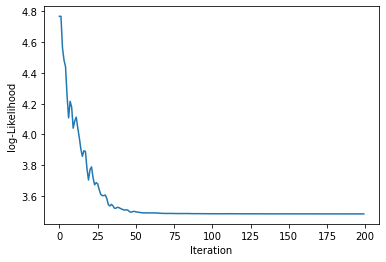

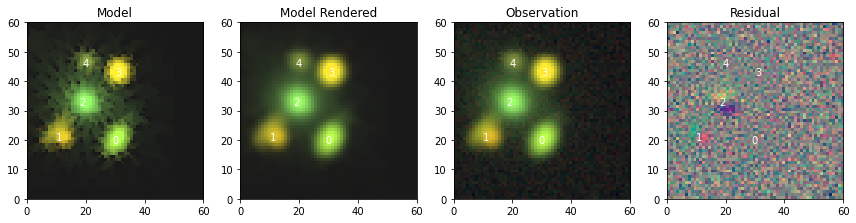

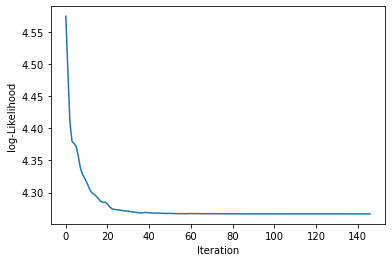

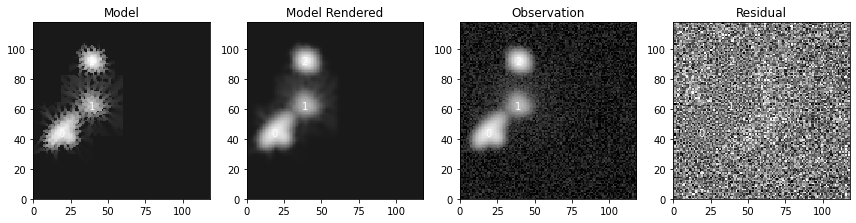

No PSF specified. Possible, but dangerous!
No PSF specified. Possible, but dangerous!
Zero or negative spectrum [-3.6972809] at [ 0.33681662 -0.57823082]
No flux in morphology model for source at [ 0.33681662 -0.57823082]
No flux in morphology model for source at [ 0.33679294 -0.57696909]


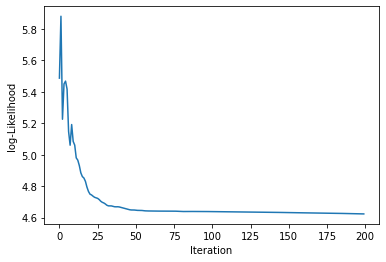

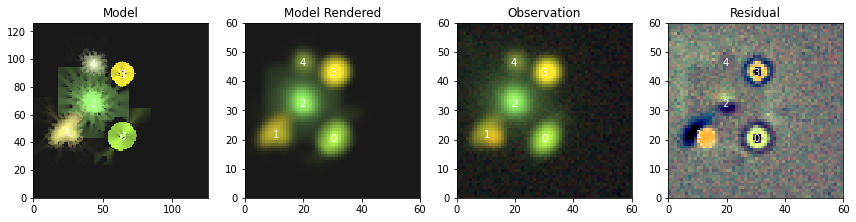

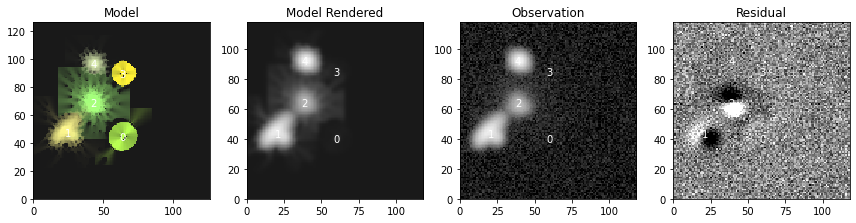

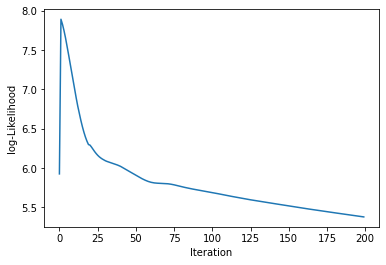

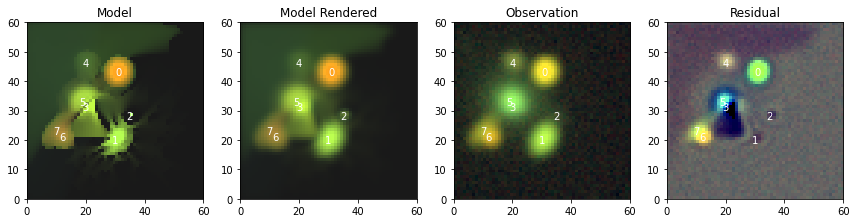

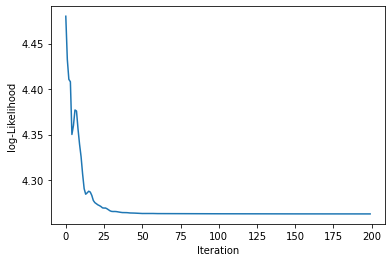

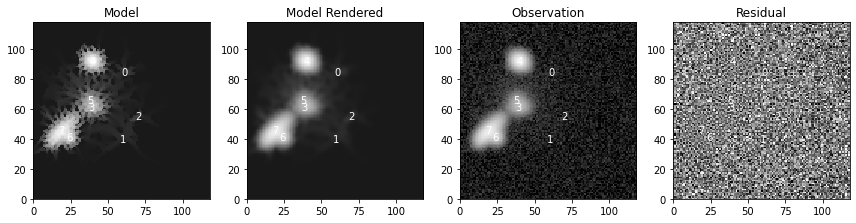

ValueError: cannot reshape array of size 1 into shape (2)

In [7]:

sim = Simulation(cat, runners, ngal = 10, cats = [0,0,0,1,1], hr_dict=hr_dict, lr_dict=lr_dict, n_lr=nlr)

print(sim.runners[-1].frame.shape)
try:
    sim.results = pickle.load(open("./sim_results_detection.pkl", "rb" ))
    sim.plot()
except:
    print("File not found")

sim.run(5, plot = True, norms = norms, init_param=True)
sim.plot()


In [ ]:
f = open("sim_results_detection.pkl","wb")
pickle.dump(sim.results, f)
f.close()
    
for i in range(100):
    sim.run(5, init_param=True)
    sim.plot()
    f = open("sim_results_detection.pkl","wb")
    pickle.dump(sim.results, f)
    f.close()


diff =  sim.runners[-1].observations[0]._diff_kernels[0]
diff_lr = sim.runners[0].observations[0]._diff_kernels[0]
diff_hr = sim.runners[1].observations[0]._diff_kernels[0]
from mr_tools.pictures import Pictures

In [ ]:
import galsim

dirac = galsim.Gaussian(sigma = 1.e-20).withFlux(1)

star = galsim.Convolve(dirac, pic1.psfs_obj[0]).drawImage(nx=51,
                                          ny=51,
                                          method = 'real_space',
                                          use_true_center = True,
                                          scale = 0.1).array

psf = pic1.psfs_obj[0].withFlux(1).drawImage(nx=51,
                                 ny=51,
                                 method = 'real_space',
                                 use_true_center = True,
                                 scale = 0.1).array
plt.imshow(star)
plt.colorbar()
plt.show()
plt.imshow((star-psf))
plt.colorbar()
plt.show()